# Breast cancer results

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from utilities_namespace import *
from functools import partial

In [2]:
%%capture
%load_ext rpy2.ipython
%R require(ggplot2)
%R require('ggbeeswarm')

In [3]:
from helpers.notebooks import notebooks_importer

## Data munging and benchmark setup

### Scoring functions

An overview of different scoring functions is outlined in the "Methods" notebook.

A concise list of all metrics used for benchmarking (with parameters) is available in "Benchmarking setup" notebook.

In [4]:
%%capture
from Benchmarking_setup import (
    tested_scoring_functions,
    tested_single_sample_functions,
    tested_multi_sample_functions,
    # diregarded as being way too slow, but their benchmark with timings belongs here
    single_sample_gene_set_based,
    # it is always good to know if the results are better than by chance
    ss_random_normal_score,    # single sample version 
    ms_random_normal_score     # multi sample version
)

In [5]:
assert tested_scoring_functions == (
    tested_single_sample_functions + tested_multi_sample_functions
)

In [6]:
[func.__name__ for func in tested_scoring_functions]

['score_spearman',
 'x_sum',
 'x_product',
 'x_cos',
 'connectivity_score_signature_kolmogorov_smirnov_conditional_difference',
 'connectivity_score_signature_kolmogorov_smirnov_difference',
 'connectivity_score_signature_cramér_von_mises_difference',
 'pharmaco_gx_connectivity_score',
 'plage_None_mx_diff:True',
 'gsva_None_mx_diff:True',
 'ssgsea_None_mx_diff:True',
 'zscore_None_mx_diff:True',
 'roast_score',
 'cudaGSEA_1000_c2.cp.kegg_mean_0.5_fill_0_True_phenotype_twopass_signal2noise',
 'cudaGSEA_1000_c2.cp.reactome_mean_0.5_fill_0_True_phenotype_twopass_signal2noise',
 'cudaGSEA_1000_h.all_mean_0.5_fill_0_True_phenotype_twopass_signal2noise']

### Data for Drug-BRCA associations

In [7]:
%%capture
import Breast_cancer_data as data_brca

### Tested substances

In [8]:
from data_sources.drug_connectivity_map import DrugConnectivityMap
dcm = DrugConnectivityMap()

In [9]:
queried_signatures = set(data_brca.indications_singatures) | set(data_brca.contraindications_singatures)

In [10]:
queried_substances = dcm.identify_substances(queried_signatures)

In [11]:
all_other_signatures = dcm.all_signatures_except(queried_substances)

In [12]:
all_other_substances = dcm.identify_substances(all_other_signatures)

In [13]:
len(all_other_signatures), len(all_other_substances)

(470593, 28872)

Note: testing all the signatures would not be feasible as:

In [14]:
feasibility_subset_signatures = len(queried_signatures)
x_time_more_needed = len(all_other_signatures) / feasibility_subset_signatures

# timings in the feasibility subset:
fastest_function = 20 # seconds

fastest_function * x_time_more_needed / 60 / 60 # hours

2.703625186717224

and that would be a single repeat of the fastest function - now way to systematically apply this with 1000s of permutations

In [ ]:
len(data_brca.all_control_signatures.columns), len(dcm.identify_substances(data_brca.all_control_signatures))

(157, 11)

#### Selection of substances and signatures for tests:

Only exemplar compounds with at least 7 signatures were selected:

In [ ]:
all_selected_compounds = (
    dcm.sig_metrics[dcm.sig_metrics.is_exemplar == 1]
    .query('pert_type == "trt_cp"')
    .groupby('pert_iname')
    .filter(lambda signatures: len(signatures) >= 7)
)

Which means testing:

In [ ]:
len(set(all_selected_compounds.pert_iname)) / len(all_other_substances) * 100

18.93183707398171

percent of all available substances.

Or 15.5% of signatures:

In [ ]:
len(all_selected_compounds) / len(all_other_signatures) * 100

15.48769318710648

In [ ]:
other_compounds = all_selected_compounds[
    ~all_selected_compounds.pert_iname.isin(queried_substances)
]

In [ ]:
%%time
all_other_selected = dcm.from_ids(other_compounds.sig_id)

CPU times: user 1min 38s, sys: 8 s, total: 1min 46s
Wall time: 3min 6s


In [ ]:
all_other_selected

,CPC004_A375_6H:BRD-K20482099-001-01-1:10,CPC004_A375_6H:BRD-K03670461-001-02-0:10,CPC004_A375_6H:BRD-K36737713-001-01-6:10,CPC004_A375_6H:BRD-A14966924-001-03-0:10,CPC004_A375_6H:BRD-K30020243-051-01-7:10,...,PCLB003_PC3_24H:BRD-K75295174-001-01-9:10,PCLB003_PC3_24H:BRD-K67174588-048-03-3:10,PCLB003_PC3_24H:BRD-K10466330-001-01-5:10,PCLB003_PC3_24H:BRD-K64106162-001-02-3:3.33,PCLB003_PC3_24H:BRD-K16956545-001-01-0:0.04
b'5720',-5.449666,-5.388713,-1.000240,0.063297,0.287297,...,0.114859,-0.069480,0.395639,-1.723814,0.499985
b'466',2.393775,1.867731,-1.106092,-0.962553,-0.873302,...,1.129740,-0.050531,-0.070778,0.147299,0.087371
b'6009',1.279790,0.281383,-0.422545,0.521553,0.183149,...,0.022448,-0.567132,0.065098,2.317295,-0.770293
b'2309',2.167868,1.378175,0.406279,0.182361,-0.040223,...,0.368490,0.107273,3.052062,0.023689,2.499663
b'387',2.333199,1.290522,-0.218671,0.572183,-0.652051,...,-1.945151,0.273071,-1.483670,0.981773,-0.142828
...,...,...,...,...,...,...,...,...,...,...,...
b'25960',3.620893,0.874223,-0.092895,0.093789,-0.033038,...,-0.162809,-0.162527,-0.204667,0.477723,-0.268085
b'6376',-1.866171,-2.777992,0.924472,-0.062907,0.551864,...,1.622637,-1.659040,0.804572,0.234113,-0.500623
b'11033',2.035219,-0.140473,1.190756,-0.417451,0.388144,...,0.641873,-0.730780,-0.775066,2.034821,-0.435387
b'54869',2.424871,1.533514,1.030570,0.401086,0.502019,...,0.282465,-0.028903,1.350826,-0.698816,0.835905


### Benchmarking setup

In [ ]:
%%capture
from Benchmarking_setup import standard_benchmark

In [ ]:
brca_standard_benchmark = partial(
    standard_benchmark,
    
    # query (breast cancer differential profile) for single-sample functions 
    query_signature=data_brca.query_signature,
    # query (breast cancer normalized expression data) for multi-sample functions:
    query_expression=data_brca.brca_with_controls,
    
    # force the pipline to show full progress and use
    # my custom multiprocessing (which is more reliable)
    per_test_progress=True 
)

In [ ]:
brca_full_benchmark = partial(
    brca_standard_benchmark,
    indications_signatures=data_brca.indications_singatures,
    contraindications_signatures=data_brca.contraindications_singatures,
    control_signatures=data_brca.all_control_signatures,
    unassigned_signatures=all_other_selected
)

In [ ]:
brca_all_known_benchmark = partial(
    # indications, contraindications and controls all have known effect
    brca_standard_benchmark,
    indications_signatures=data_brca.indications_singatures,
    contraindications_signatures=data_brca.contraindications_singatures,
    control_signatures=data_brca.all_control_signatures,
)

In [ ]:
brca_minimal_benchmark = partial(
    # this is absolute minimum to say if the scoring function has any value
    # note: using contraindications, not controls as:
    # - there are not controls for controls for multi-sample functions
    # - controls (DMSO) seem to have very little biological effect
    brca_standard_benchmark,
    indications_signatures=data_brca.indications_singatures,
    contraindications_signatures=data_brca.contraindications_singatures
)

And some utility functions:

In [ ]:
from signature_scoring.evaluation.reevaluation import extract_scores_from_result

In [ ]:
def functions_names(scoring_functions):
    return [f.__name__ for f in scoring_functions]

# Results

### Random results - for reference

In [ ]:
random_iterations = 100

In [ ]:
single_sample_random_results = brca_all_known_benchmark(
    funcs=[ss_random_normal_score] * random_iterations
    # please, note: no random scores generation for unassigned signatures,
    # no need to compare with those as we do not know much about them anyway
)

In [149]:
# %store single_sample_random_results

Stored 'single_sample_random_results' (DataFrame)


In [ ]:
multi_sample_random_results = brca_minimal_benchmark(
    funcs=[ms_random_normal_score] * random_iterations
)

In [701]:
# %store multi_sample_random_results

Stored 'multi_sample_random_results' (DataFrame)


In [ ]:
ss_gene_sets_random_results = brca_minimal_benchmark(
    funcs=[ss_random_normal_score] * random_iterations
)

In [1095]:
# %store ss_gene_sets_random_results

Stored 'ss_gene_sets_random_results' (DataFrame)


For reloading:

In [ ]:
%store -r single_sample_random_results
%store -r multi_sample_random_results
%store -r ss_gene_sets_random_results

## Singe-sample scoring functions

Singe-sample scoring functions are analyzed first and involve scoring of both: controls and all unassigned signatures (which is not feasible for multi-sample functions).

In [ ]:
results_single_sample = brca_full_benchmark(tested_single_sample_functions)

In [141]:
# %store results_single_sample

Stored 'results_single_sample' (DataFrame)


In [ ]:
%store -r results_single_sample

A brief summary, using the old approach first (compute statistics per-cell line then average; please note that this ranking is not very reliable as some metrics are repeated in slight variants introducing unfair weights - and why one would give equal or any weight to particular metrics in the first place? - the only sensible reasoning would be weighted AUC at specific cutoffs):

In [1149]:
summarize(results_single_sample)

And then using the new, better way:

In [364]:
scores = extract_scores_from_result(
    results_single_sample['meta:Scores'],
    scores_as_series=False
)
# warning: legacy computations workaround (only the name has changed)
scores.group = scores.group.replace({'unknown_status': 'unassigned'})

In [365]:
scores.to_csv('results_single_sample.csv', index=False)

The plotting with R crashes for the first time but it works fine after re-loading from file (it may be some difficulty of rpy2 conversion with non-typical numpy/pandas layout/memory blocks - though why would there be any?):

In [366]:
scores = read_csv('results_single_sample.csv', index_col=0).reset_index()

In [367]:
def categorize_values(scores):
    categoricals = ['pert_iname', 'group', 'pert_idose', 'func', 'cell_id']
    for categorical in categoricals:
        if categorical in scores.columns:
            scores[categorical] = pd.Categorical(scores[categorical])
    import gc; gc.collect();
    return scores

In [368]:
scores = categorize_values(scores)

In [369]:
nice_function_names = {
    'connectivity_score_signature_kolmogorov_smirnov_conditional_difference': "Connectivity Score' (CS')",
    'pharmaco_gx_connectivity_score': "CS'_{PharmacoGx}",
    'connectivity_score_signature_kolmogorov_smirnov_difference': "CS'_{difference} (RGES)",
    'connectivity_score_signature_cramér_von_mises_difference': "CS'_{Cramér–von Mises}",
    'score_spearman': "Spearman'",
    'x_cos': 'XCos',
    'x_sum': 'XSum',
    'x_product': 'XProduct',
    'random_normal_score': 'Random from normal distribution'
}

In [370]:
def rename_and_order_func(scores, nice_function_names):
    scores.func = scores.func.cat.rename_categories(nice_function_names)
    scores.func = pd.Categorical(scores.func, ordered=True, categories=[
        name
        for name in nice_function_names.values()
        if name in scores.func.unique()
    ])
    return scores

In [371]:
scores = rename_and_order_func(scores, nice_function_names)

In [372]:
scores.group = pd.Categorical(scores.group, ordered=True, categories=[
    'contraindications', 'indications', 'controls', 'unassigned'
])

In [373]:
from signature_scoring.evaluation.analysis import normalize_scores
show_source(normalize_scores)

In [374]:
scores = normalize_scores(scores, rescale=True, by_cell=True)

In [375]:
def add_helper_columns(scores):
    scores['is_indication'] = scores.group == 'indications' 
    scores['is_indication'] = pd.Categorical(scores.is_indication)
    scores['known_indication'] = scores['is_indication'].cat.rename_categories({
        True: 'known indications',
        False: 'non-indications'
    })
    return scores

In [376]:
scores = add_helper_columns(scores)

### Distribution plot

Here I try to assign semantically-resonant colors (green - for indications, red - for contraindications, some pale color - for controls, some meaningless violet - for unassigned signatures). But I am also a bit colorblind, so it may not look so pretty to other people (feedback is welcome):

In [1166]:
%%R
colors = scale_color_manual(guide='none', values=c(
    controls='#00C3C4',
    indications='#63BD00',
    contraindications='#FF6468',
    unassigned='#f97cf5'
))

/home/krassowski/.pyenv/versions/3.7.0/envs/drug_discovery/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "is_indication". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  (name, str(e)))


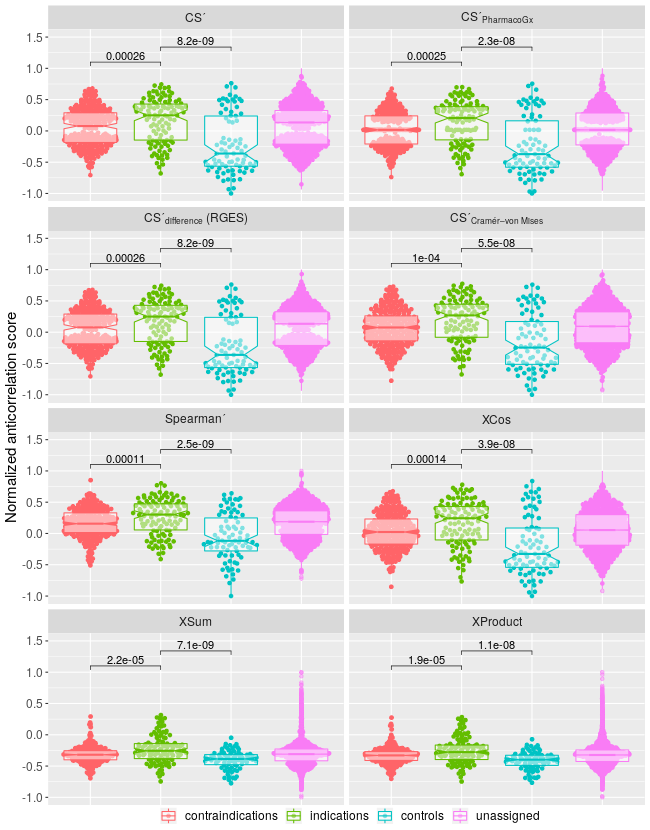

In [1478]:
%%R -i scores -w 650 -h 830

distribution_plot <- function(scores, to_compare, ncol=2, n=5000, top_lim=1.5) {
    levels(scores$func) = sapply(levels(scores$func), latex2exp::TeX, 'expression')

    if (any(scores$group == 'unassigned')) {
        # due to memory limitations, only n randomly selected unassigned profiles are plotted.
        unassigned_rows <- which(scores$group=='unassigned')
        unassigned <- scores[sample(unassigned_rows, n),]
        managable_subset <- rbind(scores[scores$group != 'unassigned',], unassigned)
    } else {
        managable_subset <- scores 
    }

    g <- (
        ggplot(scores, aes(x=group, y=score, color=group))
        + facet_wrap('~ func', labeller=label_parsed, ncol=ncol)
        + geom_quasirandom(data=managable_subset)
        + geom_boxplot(notch=T, alpha=0.5)
        + colors
        + theme(
            legend.position='bottom',
            legend.box='horizontal',
            text=element_text(size=15),
            #axis.text.x=element_text(angle=45, hjust=1)
            axis.ticks.x=element_blank(),
            axis.text.x=element_blank(),
            legend.margin=margin(t=-1, unit='cm')
        )
        + guides(color=guide_legend(title=''))
        + xlab('')
        + ylab('Normalized anticorrelation score')
        + ggpubr::stat_compare_means(
            comparisons=to_compare,
            method="wilcox.test",
            method.args=list(alternative="greater")
        )
        + ylim(-1, top_lim)
    )
    g
}

g = distribution_plot(
    scores,
    to_compare=list(
        c("indications", "contraindications"),
        c("indications", "controls")
    )
)
ggsave(file="single_sample_BRCA.png", plot=g, width=6.5*1.3, height=8.3*1.3)
g

### Rank plot (khinkali)

In [377]:
from helpers.r import r_ks_test

In [378]:
scores.func = scores.func.cat.rename_categories({"Connectivity Score' (CS')": "CS'"})

In [379]:
def rank_by_func(scores):
    scores['rank'] = scores.groupby('func').score.rank(ascending=False, method='first')
    return scores

In [380]:
scores = rank_by_func(scores)

In [381]:
from signature_scoring.evaluation.analysis import test_rank_diff_indications_vs_non_indications
show_source(test_rank_diff_indications_vs_non_indications)

In [382]:
ks_annotations = test_rank_diff_indications_vs_non_indications(scores)
ks_annotations['p_value_short'] = ks_annotations['p.value'].astype(float).apply(
    lambda s: f'{s:.2e}'
)
ks_annotations.head()

level_1,alternative,method,p.value,statistic,p_value_short
func,,,,,
CS',the CDF of x lies above that of y,Two-sample Kolmogorov-Smirnov test,0.000437849,0.185242,4.38e-04
CS'_{PharmacoGx},the CDF of x lies above that of y,Two-sample Kolmogorov-Smirnov test,2.21063e-05,0.218091,2.21e-05
CS'_{difference} (RGES),the CDF of x lies above that of y,Two-sample Kolmogorov-Smirnov test,0.000374297,0.187111,3.74e-04
CS'_{Cramér–von Mises},the CDF of x lies above that of y,Two-sample Kolmogorov-Smirnov test,9.98245e-05,0.202175,9.98e-05
Spearman',the CDF of x lies above that of y,Two-sample Kolmogorov-Smirnov test,0.000289159,0.190146,2.89e-04


In [383]:
is_indication = (scores.group == 'indications')
indications_by_func = scores[is_indication].groupby('func')

In [384]:
from signature_scoring.evaluation.analysis import n_best_scoring

In [385]:
top_indication_scores = n_best_scoring(scores, indications_by_func, n=1)

In [386]:
top_indication_scores

,Index,cell_id,group,pert_idose,pert_iname,score,raw_score,is_indication,known_indication,rank
func,,,,,,,,,,
CS',0,PC3,indications,10 µM,everolimus,0.743945,0.429000,True,known indications,232.0
CS'_{PharmacoGx},0,PC3,indications,10 µM,everolimus,0.700444,0.423055,True,known indications,256.0
CS'_{difference} (RGES),0,PC3,indications,10 µM,everolimus,0.743731,0.429000,True,known indications,234.0
CS'_{Cramér–von Mises},0,PC3,indications,10 µM,everolimus,0.773961,139.194685,True,known indications,245.0
Spearman',0,A375,indications,10 µM,tamoxifen,0.802352,0.512912,True,known indications,75.0
XCos,0,VCAP,indications,10 µM,epirubicin,0.780163,1.491143,True,known indications,210.0
XSum,0,VCAP,indications,10 µM,epirubicin,0.314444,967.586731,True,known indications,174.0
XProduct,0,VCAP,indications,10 µM,epirubicin,0.281584,902.475909,True,known indications,176.0


In [387]:
best_recovery = top_indication_scores['rank']
best_recovered_pert = top_indication_scores.pert_iname

In [388]:
annotations = ks_annotations.assign(
    best_recovery=best_recovery,
    best_recovered_pert=best_recovered_pert
).reset_index()
annotations

level_1,func,alternative,method,p.value,statistic,p_value_short,best_recovery,best_recovered_pert
0,CS',the CDF of x lies above that of y,Two-sample Kolmogorov-Smirnov test,0.000437849,0.185242,4.38e-04,232.0,everolimus
1,CS'_{PharmacoGx},the CDF of x lies above that of y,Two-sample Kolmogorov-Smirnov test,2.21063e-05,0.218091,2.21e-05,256.0,everolimus
2,CS'_{difference} (RGES),the CDF of x lies above that of y,Two-sample Kolmogorov-Smirnov test,0.000374297,0.187111,3.74e-04,234.0,everolimus
3,CS'_{Cramér–von Mises},the CDF of x lies above that of y,Two-sample Kolmogorov-Smirnov test,9.98245e-05,0.202175,9.98e-05,245.0,everolimus
4,Spearman',the CDF of x lies above that of y,Two-sample Kolmogorov-Smirnov test,0.000289159,0.190146,2.89e-04,75.0,tamoxifen
5,XCos,the CDF of x lies above that of y,Two-sample Kolmogorov-Smirnov test,0.000117429,0.200385,1.17e-04,210.0,epirubicin
6,XSum,the CDF of x lies above that of y,Two-sample Kolmogorov-Smirnov test,1.69186e-05,0.220795,1.69e-05,174.0,epirubicin
7,XProduct,the CDF of x lies above that of y,Two-sample Kolmogorov-Smirnov test,4.13382e-05,0.211628,4.13e-05,176.0,epirubicin


In [389]:
annotations['best_label'] = annotations.apply(
    lambda x: f' {x["best_recovered_pert"]}        {int(x["best_recovery"])}',
    axis=1
)

In [411]:
%%R

source('../../thirdparty/reverselog_trans.R')

khinkali_p_values <- function(annotations, group_for_annotations='known indications') {
    geom_text(data=annotations, aes(
        label=p_value_short, y=1.5, x=-Inf,
        group=group_for_annotations,
        fill=group_for_annotations,
        hjust=-0.1
    ))
}

khinkali_plot <- function(scores, ncol=4, scales='fixed', width=1) {

    g = (
        ggplot(scores, aes(x=1, y=rank, group=known_indication, fill=known_indication, width=width))
        + facet_wrap('~ func', labeller=label_parsed, ncol=ncol, scales=scales)
        + geom_violin(data=scores[scores$group == 'indications',], alpha=0.5)
        + geom_violin(data=scores[scores$group != 'indications',], alpha=0.35)
        + theme(
            legend.position='bottom',
            legend.box='horizontal',
            text=element_text(size=15),
            axis.text.x=element_blank(),
            axis.ticks.x=element_blank()
        )
        + guides(fill=guide_legend(title=''))
        + xlab('')
        + ylab('Rank of a score of a perturbation profile')
        + scale_y_continuous(trans=reverselog_trans(10))
        + scale_fill_discrete(direction=1)
        #+ scale_x_continuous(limits = c(-0, 1.5)) 
    )
    g
}

khinkali_fill_colors <- function(indications='#2CA02C', non_indications='#E377C2') {
    scale_fill_manual(guide='none', values=c(
        'known indications'=indications,
        'non-indications'=non_indications
    ))
}

/home/krassowski/.pyenv/versions/3.7.0/envs/drug_discovery/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "is_indication". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  (name, str(e)))


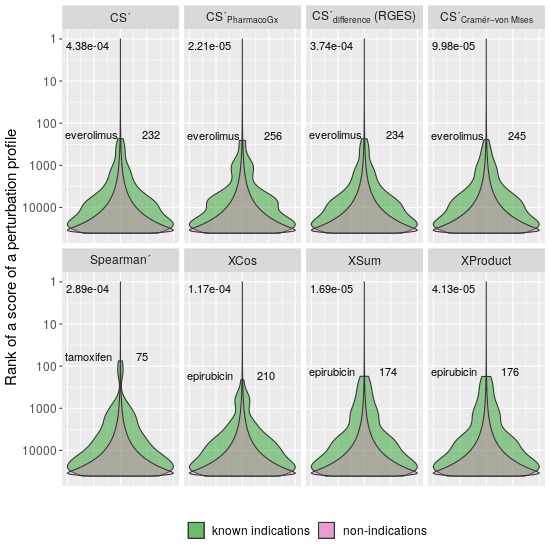

In [412]:
%%R -i scores -w 550 -h 550 -i annotations

levels(scores$func) = sapply(levels(scores$func), latex2exp::TeX, 'expression')
levels(annotations$func) = sapply(levels(annotations$func), latex2exp::TeX, 'expression')

group_for_annotations <- 'known indications'

g = (
    khinkali_plot(scores)
    # annotate with the top recovered drug to show an example (and where we really are)
    + geom_text(
        data=annotations,
        aes(
            label=best_label, y=best_recovery, x=-Inf,
            group=group_for_annotations,
            fill=group_for_annotations,
            hjust=0, vjust=-(best_recovery==322)/2 # shift the overlapping label
        ),
        color='black'
    )
    + khinkali_fill_colors()
    + khinkali_p_values(annotations)
)
ggsave(file="single_sample_BRCA_among_all.png", plot=g, width=5.5*1.4, height=5.5*1.4)
g

### Scores similarity clustering 

In [1241]:
from signature_scoring.evaluation.analysis import distance_matrix
show_source(distance_matrix)

In [1447]:
matrix = distance_matrix(scores)
matrix

,Spearman',XSum,XProduct,XCos,CS',CS'_{difference} (RGES),CS'_{Cramér–von Mises},CS'_{PharmacoGx}
Spearman',0.0,0.979527,1.000000,0.224069,0.288454,0.289968,0.192871,0.337724
XSum,0.0,0.000000,0.067066,0.760789,0.720726,0.719180,0.788297,0.749600
XProduct,0.0,0.000000,0.000000,0.783091,0.746625,0.744732,0.807886,0.757518
XCos,0.0,0.000000,0.000000,0.000000,0.113312,0.112366,0.058644,0.116651
CS',0.0,0.000000,0.000000,0.000000,0.000000,0.011767,0.100946,0.126872
CS'_{difference} (RGES),0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.101767,0.126872
CS'_{Cramér–von Mises},0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.168418
CS'_{PharmacoGx},0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [1448]:
from signature_scoring.evaluation.analysis import clusters_from_matrix
show_source(clusters_from_matrix)

In [1492]:
clusters = clusters_from_matrix(matrix, 4)
clusters

{'PLAGE': 2,
 'GSVA': 0,
 'ssGSEA (GSVA)': 3,
 'z-score': 0,
 'mROAST': 0,
 'cudaGSEA_{KEGG}': 1,
 'cudaGSEA_{Reactome}': 1,
 'cudaGSEA_{hallmarks}': 1}

### Performance plot 

Using substances with known status only.
 
Log loss and AUC ROC based on sklearn implementation.

In [1279]:
from signature_scoring.evaluation.analysis import compute_metrics_by_func, compute_metrics

In [1280]:
metrics_by_func = compute_metrics_by_func(scores, without_unassigned=True)
metrics_by_func

,auc,auc0.01,auc0.1,func,log_loss
0,0.644535,0.515000,0.566285,Spearman',2.101083
1,0.652723,0.517293,0.592335,XSum,6.649302
2,0.652997,0.517293,0.592935,XProduct,6.833076
3,0.638696,0.507986,0.537283,XCos,3.004795
4,0.637008,0.508261,0.537775,CS',2.817912
5,0.636883,0.508261,0.537415,CS'_{difference} (RGES),2.818315
6,0.640042,0.509545,0.542109,CS'_{Cramér–von Mises},2.505579
7,0.635446,0.502806,0.544293,CS'_{PharmacoGx},2.715200


Note AUC 0.01 does not make much sense in this case as there are only a couple of substances at this level (5?).

But anyway, overall AUC and at 0.1/0.01 thresholds is kind of similar / correlated among functions:

In [1281]:
metrics_by_func[['auc', 'auc0.1', 'auc0.01']].rank()

,auc,auc0.1,auc0.01
0,6.0,6.0,6.0
1,7.0,7.0,7.5
2,8.0,8.0,7.5
3,4.0,1.0,2.0
4,3.0,3.0,3.5
5,2.0,2.0,3.5
6,5.0,4.0,5.0
7,1.0,5.0,1.0


In [1282]:
from scipy.stats import spearmanr

In [1283]:
for c in ['auc0.1', 'auc0.01']:
    print(c, spearmanr(metrics_by_func[c], metrics_by_func.auc))

auc0.1 SpearmanrResult(correlation=0.6904761904761906, pvalue=0.057990318164572716)
auc0.01 SpearmanrResult(correlation=0.9157291161525718, pvalue=0.0014031743248924412)


In [1284]:
nice_names_short = {
    **nice_function_names,
    **{"connectivity_score_signature_kolmogorov_smirnov_conditional_difference": "CS'"}
}

In [1285]:
def functions_summary_frame(result, clusters, metrics, nice_names):
    timings = result.Time.reset_index()
    timings.columns = timings.columns.str.lower()
    timings['func'] = timings.func.map(nice_names)
    
    clusters_df = Series(clusters).reset_index().rename({'index': 'func', 0: 'cluster'}, axis=1)

    summary = metrics.merge(timings).merge(clusters_df)
    
    summary.cluster = pd.Categorical(summary.cluster.astype(str))
    summary = summary.assign(time_rank=summary.time.rank())
    return summary

In [1286]:
single_sample_summary = functions_summary_frame(
    results_single_sample, clusters,
    metrics_by_func, nice_names_short
)
single_sample_summary

,auc,auc0.01,auc0.1,func,log_loss,time,cluster,time_rank
0,0.644535,0.515000,0.566285,Spearman',2.101083,286.774986,2,1.0
1,0.652723,0.517293,0.592335,XSum,6.649302,287.927841,1,2.0
2,0.652997,0.517293,0.592935,XProduct,6.833076,328.372540,1,4.0
3,0.638696,0.507986,0.537283,XCos,3.004795,324.445174,0,3.0
4,0.637008,0.508261,0.537775,CS',2.817912,337.835236,0,5.0
5,0.636883,0.508261,0.537415,CS'_{difference} (RGES),2.818315,339.457864,0,6.0
6,0.640042,0.509545,0.542109,CS'_{Cramér–von Mises},2.505579,345.671334,0,7.0
7,0.635446,0.502806,0.544293,CS'_{PharmacoGx},2.715200,3680.535241,3,8.0


In [1287]:
single_sample_summary = functions_summary_frame(
    results_single_sample, clusters,
    metrics_by_func, nice_names_short
)
single_sample_summary

,auc,auc0.01,auc0.1,func,log_loss,time,cluster,time_rank
0,0.644535,0.515000,0.566285,Spearman',2.101083,286.774986,2,1.0
1,0.652723,0.517293,0.592335,XSum,6.649302,287.927841,1,2.0
2,0.652997,0.517293,0.592935,XProduct,6.833076,328.372540,1,4.0
3,0.638696,0.507986,0.537283,XCos,3.004795,324.445174,0,3.0
4,0.637008,0.508261,0.537775,CS',2.817912,337.835236,0,5.0
5,0.636883,0.508261,0.537415,CS'_{difference} (RGES),2.818315,339.457864,0,6.0
6,0.640042,0.509545,0.542109,CS'_{Cramér–von Mises},2.505579,345.671334,0,7.0
7,0.635446,0.502806,0.544293,CS'_{PharmacoGx},2.715200,3680.535241,3,8.0


Some functions may refuse to work with certain signatures, though it should be highly exceptional:

In [1288]:
def count_substances(scores):
    return (
        scores.groupby('func').pert_iname.apply(
            lambda x: len(set(x))
        ).to_dict()
    )

substances_count = count_substances(scores)
substances_count

{"CS'": 5424,
 "CS'_{PharmacoGx}": 5424,
 "CS'_{difference} (RGES)": 5424,
 "CS'_{Cramér–von Mises}": 5424,
 "Spearman'": 5424,
 'XCos': 5424,
 'XSum': 5424,
 'XProduct': 5424}

In [1289]:
def nice_time(t):
    # t is in seconds
    if t > 60*60:
        return f'{t//60:.0f}m {t - t//60*60:.0f}s'
    if t < 1:
        return f'{round(t * 1000)} ms'
    else:
        return f'{t:.2f}s'

def add_time_per_substance(summary, substances_count):
    summary['time_per_substance'] = summary.apply(
        lambda t: t['time'] / substances_count[t['func']],
        axis=1
    )
    summary['time_nice'] = summary.time_per_substance.apply(nice_time)
    return summary

In [1290]:
single_sample_summary = add_time_per_substance(single_sample_summary, substances_count)
single_sample_summary

,auc,auc0.01,auc0.1,func,log_loss,time,cluster,time_rank,time_per_substance,time_nice
0,0.644535,0.515000,0.566285,Spearman',2.101083,286.774986,2,1.0,0.052871,53 ms
1,0.652723,0.517293,0.592335,XSum,6.649302,287.927841,1,2.0,0.053084,53 ms
2,0.652997,0.517293,0.592935,XProduct,6.833076,328.372540,1,4.0,0.060541,61 ms
3,0.638696,0.507986,0.537283,XCos,3.004795,324.445174,0,3.0,0.059817,60 ms
4,0.637008,0.508261,0.537775,CS',2.817912,337.835236,0,5.0,0.062285,62 ms
5,0.636883,0.508261,0.537415,CS'_{difference} (RGES),2.818315,339.457864,0,6.0,0.062584,63 ms
6,0.640042,0.509545,0.542109,CS'_{Cramér–von Mises},2.505579,345.671334,0,7.0,0.063730,64 ms
7,0.635446,0.502806,0.544293,CS'_{PharmacoGx},2.715200,3680.535241,3,8.0,0.678565,679 ms


#### Adding random scores performance:

In [1291]:
def random_scores_metrics(random_result, are_grouped_by_cell):
    if len(random_result.index) != len(random_result.index.unique()):
        random_result.index = random_result.index + '_' + Series(
            map(str, range(len(random_result)))
        )
    random_scores = extract_scores_from_result(
        random_result['meta:Scores'],
        scores_as_series=False,
        are_grouped_by_cell=are_grouped_by_cell
    )
    random_scores = add_helper_columns(random_scores)
    return compute_metrics_by_func(random_scores, without_unassigned=True)

In [1292]:
random_metrics_ss = random_scores_metrics(single_sample_random_results, are_grouped_by_cell=True)
random_metrics_ss.head()

,auc,auc0.01,auc0.1,func,log_loss
0,0.541625,0.499505,0.521605,ss_random_normal_score_0,7.511885
1,0.526001,0.506244,0.518004,ss_random_normal_score_1,7.754228
2,0.474364,0.499642,0.489002,ss_random_normal_score_2,8.839712
3,0.509967,0.501934,0.492075,ss_random_normal_score_3,8.035386
4,0.475572,0.499642,0.491355,ss_random_normal_score_4,8.029326


In [122]:
%%R
source('../../helpers/plots/utilities.R')

performance_plot = function(
    s, random, outlier_cutoff, margin=0.5, adjustment=c(log_loss_gird_extend_left=0),
    left=c(breaks.zoom=1, minor_breaks.zoom=10),
    right=c(breaks.zoom=1, minor_breaks.zoom=10),
    up=c(unit='ms', factor=1000),
    label.theme=list(
        angle=0, size=9,
        vjust=7.25, color='white'
    )
) {
    s$auc_scaled = trans(s$auc, s$auc, margin)
    s$log_loss_scaled = trans(s$log_loss, s$log_loss, margin)

    s$func = sapply(s$func, latex2exp::TeX, 'character')
    s$func = sapply(s$func, function(l) paste("bold(", l, ")"))
    outlierts = s$time > outlier_cutoff
    s$time_outlier = NA
    s$time_outlier[outlierts] = 'outlier'

    breaks_auc = trans_seq(s$auc, margin=margin, side=-1, zoom=left['breaks.zoom'])
    breaks_loss = trans_seq(s$log_loss, margin=margin, side=+1, zoom=right['breaks.zoom'], start_adjustment=adjustment['log_loss_gird_extend_left'])
    
    g = (
        ggplot(s, aes(y=time_rank))
        + geom_segment(aes(x=0, xend=0, y=min(time_rank), yend=max(time_rank)), color='grey')
        + geom_segment(aes(x=-auc_scaled, xend=log_loss_scaled, y=time_rank, yend=time_rank), color='grey')
        + geom_point(aes(color=cluster, x=log_loss_scaled), size=11)
        + geom_point(aes(color=cluster, x=-auc_scaled), size=11)
        + shadowtext::geom_shadowtext(
            aes(
                label=substring(sprintf("%.3f", round(auc, digits=5)), 2),
                x=-auc_scaled
            ),
            color='white',
            bg.r=0.05,
            bg.color='#999999',
            size=3.3
        )
        + shadowtext::geom_shadowtext(
            aes(
                label=sprintf("%0.2f", round(log_loss, digits=2)),
                x=log_loss_scaled
            ),
            #bg.
            color='white',
            bg.r=0.05,
            bg.color='#999999',
            size=3.3
        )
        + geom_label(
            data=s[!outlierts,], aes(label=func, x=0, fill=time_per_substance * as.numeric(up[['factor']])), color='white', parse=T, size=3.1, label.padding=unit(0.3, 'lines'))
        + scale_fill_gradient(
            low="#00B700", high="#EABB41",
            labels=function(x) sprintf("%.0f", x)
        )
        + shadowtext::geom_shadowtext(
            aes(label=time_nice, x=0),
            color='black', position=position_nudge(y=-0.3),
            bg.color='white',
            bg.r=0.2,
            size=2.6
        )
        + xlab('← AUC ROC\t\t     \t\tLog Loss → ')
        + theme_minimal()
        + theme(
            legend.position='bottom',
            legend.box='horizontal',
            text=element_text(size=10),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),

        )
        + ylab('')
        + guides(
            color=guide_legend(
                title='Cluster',
                label=F,
                keywidth=.5,
                override.aes=list(size=5)
            ),
            fill=guide_colorbar(
                label=T,
                title=sprintf('Time per substance [%s]', up['unit']),
                label.position = "bottom",
                title.theme = element_text(vjust=0.85, size=10),
                label.theme = do.call(element_text, label.theme)
            )
        )
        + scale_x_continuous(
            minor_breaks=c(
                trans_seq(s$auc, margin=margin, side=-1, zoom=left['minor_breaks.zoom'], end_shift=0.01),
                trans_seq(s$log_loss, margin=margin, side=+1, zoom=right['minor_breaks.zoom'], end_shift=0.01)
            ),
            breaks=c(
                breaks_auc,
                breaks_loss
            ),
            labels=c(
                labels_seq(s$auc, side=-1, zoom=left['breaks.zoom'])[1:length(breaks_auc)],
                labels_seq(s$log_loss, side=+1, zoom=right['breaks.zoom'])[1:length(breaks_loss)]
            )
        )
        + annotate('text', x=-(1.1 + margin), y=max(s$time_rank) + 0.5, label=sprintf(
            "Expected: %.2f ± %.2f", median(random$auc), sd(random$auc)),
            hjust=0, size=3.1, color='#666666'
        )
        + annotate('text', x=+(1.1 + margin), y=max(s$time_rank) + 0.5, label=sprintf(
            "Expected: %.2f ± %.2f", median(random$log_loss), sd(random$log_loss)),
            hjust=1, size=3.1, color='#666666'
        )
    )
    
    if(any(outlierts)) {
        g = (
            g
            + geom_label(
                data=s[outlierts,], 
                aes(label=func, x=0, group=time_per_substance),
                show.legend='group',
                fill='#FF3900', color='white',
                parse=T, size=3.1, label.padding=unit(0.3, 'lines')
            )
        )
    }
    (
        g
        + shadowtext::geom_shadowtext(aes(label=func, x=0), parse=T, size=3.1, bg.r=0.05, bg.color='#888888')
    )
}

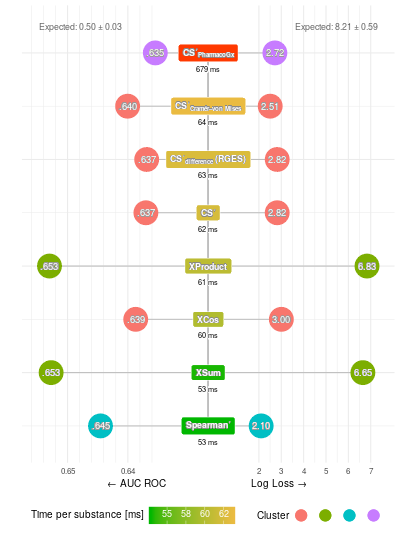

In [1432]:
%%R -i single_sample_summary -i random_metrics_ss -w 400 -h 550 -u px
single_sample_comparison = performance_plot(
    single_sample_summary, random_metrics_ss, outlier_cutoff=60*60,
    adjustment=c(log_loss_gird_extend_left=0.05),
    left=c(breaks.zoom=100, minor_breaks.zoom=500),
    right=c(breaks.zoom=1, minor_breaks.zoom=2)
)
ggsave(
    file="single_sample_BRCA_comparison.png",
    plot=single_sample_comparison,
    width=4*1.3, height=5.5*1.3, dpi=350
)
single_sample_comparison

We want the log loss to be low and AUC ROC to be high.

Some intuition on log loss:

In [1043]:
from sklearn.metrics import log_loss, roc_auc_score
                                                  # good guess, bad guess, good guess, bad guess
y_t  =                                 [  0,   0,   0,   0,   1,   1,   1]
y_p_knows_or_takes_a_brave_guess =     [0.0, 0.0, 0.2, 0.8, 0.8, 0.2, 1.0]
y_p_knows_or_takes_a_shy_guess   =     [0.0, 0.0, 0.25, 0.75, 0.75, 0.25, 1.0]
y_p_knows_or_admits_that_has_no_idea = [0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 1.0]

log_loss(y_t, y_p_knows_or_takes_a_brave_guess), roc_auc_score(y_t, y_p_knows_or_takes_a_brave_guess)

(0.523594703928089, 0.8333333333333333)

In [1044]:
log_loss(y_t, y_p_knows_or_takes_a_shy_guess), roc_auc_score(y_t, y_p_knows_or_takes_a_shy_guess)

(0.478278981020478, 0.8333333333333333)

In [1045]:
log_loss(y_t, y_p_knows_or_admits_that_has_no_idea), roc_auc_score(y_t, y_p_knows_or_admits_that_has_no_idea)

(0.396084103177112, 0.8333333333333333)

And finally, the omnipotent one:

In [1046]:
log_loss(y_t, y_t), roc_auc_score(y_t, y_t)

(9.992007221626415e-16, 1.0)

So log-loss seems to be better for drug repositioning as it will help to choose a scoring function which will prioritize (and not only select) drugs candidates, providing useful information in the score value.

### Chosen functions:

- Spearman': high AUC ROC, low log loss - such a good result is surprising given that previous publications disregarded simple correlation approaches (Cheng 2013? and RGES - they have some table in excel with benchmark summary, I need to find it for write up),
- XSum: high AUC ROC, better log loss and execution time than XProduct,
- $CS'_{CramerVonMises}$: very similar to XCos and RGES, but better in both metrics; unfortunately a bit slower

In [41]:
from Benchmarking_setup import (
    connectivity_score_cramér_von_mises,
    x_sum,
    score_spearman
)
selected_single_sample_functions = [
    connectivity_score_cramér_von_mises,
    x_sum,
    score_spearman
]

## Multi-sample

In [ ]:
results_multi_sample_all = brca_minimal_benchmark(
    # using minimal benchmark (indications and contraindications only) as multi-sample functions:
    # 1. are slow - so it takes to much time to compute values for all unassigned signatures,
    # 2. need controls - and there are no controls for controls
    tested_multi_sample_functions
)

In [136]:
# %store results_multi_sample_all

Stored 'results_multi_sample_all' (DataFrame)


In [ ]:
%store -r results_multi_sample_all

### Processing

In [250]:
multi_sample_scores = extract_scores_from_result(
    results_multi_sample['meta:Scores'],
    scores_as_series=False,
    are_grouped_by_cell=False
)
multi_sample_scores.to_csv('results_multi_sample.csv', index=False)

In [52]:
nice_multisample_function_names = {
    'plage_None_mx_diff:True': 'PLAGE',
    'gsva_None_mx_diff:True': 'GSVA',
    'ssgsea_None_mx_diff:True': 'ssGSEA (GSVA)',
    'zscore_None_mx_diff:True': 'z-score',
    'roast_score': 'mROAST',
    'cudaGSEA_1000_c2.cp.kegg_mean_0.5_fill_0_True_phenotype_twopass_signal2noise': 'cudaGSEA_{KEGG}',
    'cudaGSEA_1000_c2.cp.reactome_mean_0.5_fill_0_True_phenotype_twopass_signal2noise': 'cudaGSEA_{Reactome}',
    'cudaGSEA_1000_h.all_mean_0.5_fill_0_True_phenotype_twopass_signal2noise': 'cudaGSEA_{hallmarks}'
}

In [61]:
def process_scores(scores, names_map):
    scores = categorize_values(scores)
    scores = normalize_scores(scores, rescale=True, by_cell=False)
    scores = rename_and_order_func(scores, names_map)
    scores = add_helper_columns(scores)
    scores = rank_by_func(scores)
    return scores

In [656]:
multi_sample_scores = read_csv('results_multi_sample.csv', index_col=0).reset_index()
multi_sample_scores = process_scores(multi_sample_scores, nice_multisample_function_names)

In [657]:
multi_sample_scores.head()

,Index,func,group,pert_idose,pert_iname,score,raw_score,is_indication,known_indication
0,0,PLAGE,indications,10 µM,everolimus,1.000000,2.020610,True,known indications
1,1,PLAGE,indications,1 µM,methotrexate,0.877594,1.748053,True,known indications
2,2,PLAGE,indications,10 µM,methotrexate,0.877594,1.748053,True,known indications
3,3,PLAGE,indications,500 nM,lapatinib,0.675978,1.299122,True,known indications
4,4,PLAGE,indications,10 µM,lapatinib,0.675978,1.299122,True,known indications


GSVA-implemented functions failed to process data for fluoxymesterone (20 µM):

In [653]:
multi_sample_scores[multi_sample_scores.score.isnull()]

,Index,func,group,pert_idose,pert_iname,score,raw_score,is_indication,known_indication
74,49,PLAGE,contraindications,20 µM,fluoxymesterone,NaN,NaN,False,non-indications
149,49,GSVA,contraindications,20 µM,fluoxymesterone,NaN,NaN,False,non-indications
224,49,ssGSEA (GSVA),contraindications,20 µM,fluoxymesterone,NaN,NaN,False,non-indications
299,49,z-score,contraindications,20 µM,fluoxymesterone,NaN,NaN,False,non-indications


and these scores were dropped:

In [661]:
multi_sample_scores = multi_sample_scores.dropna()

### Distribution plot

/home/krassowski/.pyenv/versions/3.7.0/envs/drug_discovery/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "is_indication". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  (name, str(e)))


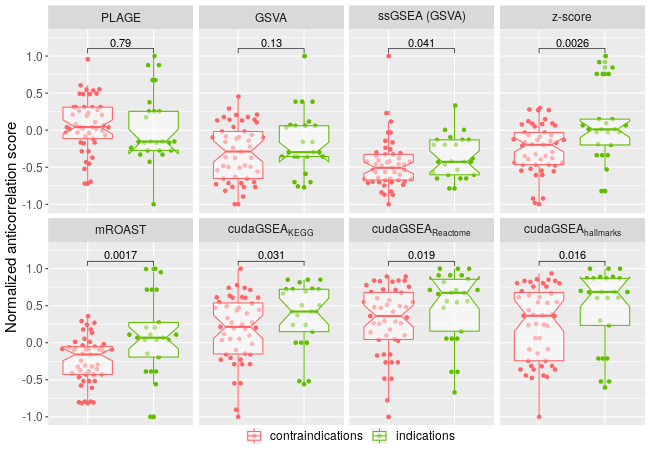

In [1481]:
%%R -i multi_sample_scores -w 650 -h 450

g = distribution_plot(
    multi_sample_scores,
    to_compare=list(
        c("indications", "contraindications")
    ),
    ncol=4,
    top_lim=1.25
)
ggsave(file="multi_sample_BRCA.png", plot=g, width=6.5*1.3, height=4.5*1.3)
g

### The PLAGE issue

In [664]:
results_multi_sample_all['contraindications:Is Mean Better']

Func
plage_None_mx_diff:True                                                             False
gsva_None_mx_diff:True                                                               True
ssgsea_None_mx_diff:True                                                             True
zscore_None_mx_diff:True                                                             True
roast_score                                                                          True
cudaGSEA_1000_c2.cp.kegg_mean_0.5_fill_0_True_phenotype_twopass_signal2noise         True
cudaGSEA_1000_c2.cp.reactome_mean_0.5_fill_0_True_phenotype_twopass_signal2noise     True
cudaGSEA_1000_h.all_mean_0.5_fill_0_True_phenotype_twopass_signal2noise              True
Name: contraindications:Is Mean Better, dtype: bool

Although PLAGE got lower mean for contraindications than indications, we can still give it a benefit of a doubt and inverse the scores (as for the classification task, the sign does not matter in the end if we can tell which group is which):

In [675]:
plage_rows = multi_sample_scores.func == 'PLAGE'
plage_subset = multi_sample_scores[plage_rows]
plage_subset.score = -plage_subset.score

Even if we do reverse the scores, the difference in distributions is not significant (and still, the worst of all tested functions):

In [676]:
%%R -i plage_subset

indications = plage_subset[plage_subset$group=='indications',]
contraindications = plage_subset[plage_subset$group=='contraindications',]

wilcox.test(indications$score, contraindications$score, alternative='greater')

/home/krassowski/.pyenv/versions/3.7.0/envs/drug_discovery/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "is_indication". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  (name, str(e)))



	Wilcoxon rank sum test with continuity correction

data:  indications$score and contraindications$score
W = 682, p-value = 0.2152
alternative hypothesis: true location shift is greater than 0



This result was consistent across multiple runs and highly suspicious, given the reports of good PLAGE performance and the use of implementation from GSVA package (same as for GSVA, zscore, and ssgsea - which performed ok), where one could expect that all the functions will report scores in the same direction.

However, for the top 10 percentile, the PLAGE results were actually not that bad:

In [677]:
plage_subset = multi_sample_scores[plage_rows]

In [678]:
plage_subset[plage_subset.score > plage_subset.score.quantile(.9)].sort_values(
    'score', ascending=False
)

,Index,func,group,pert_idose,pert_iname,score,raw_score,is_indication,known_indication
0,0,PLAGE,indications,10 µM,everolimus,1.000000,2.020610,True,known indications
25,0,PLAGE,contraindications,10 µM,ethynodiol,0.958463,1.928122,False,non-indications
1,1,PLAGE,indications,1 µM,methotrexate,0.877594,1.748053,True,known indications
2,2,PLAGE,indications,10 µM,methotrexate,0.877594,1.748053,True,known indications
3,3,PLAGE,indications,500 nM,lapatinib,0.675978,1.299122,True,known indications
4,4,PLAGE,indications,10 µM,lapatinib,0.675978,1.299122,True,known indications
26,1,PLAGE,contraindications,10 µM,quetiapine,0.606036,1.143386,False,non-indications
27,2,PLAGE,contraindications,10 µM,phylloquinone,0.552324,1.023788,False,non-indications


As it highly ranked 5 indications over only 3 contraindications profiles (though an equal number of indicated and contraindicated substances)

### Similarity clustering

In [1456]:
matrix = distance_matrix(multi_sample_scores)

In [1460]:
clusters = clusters_from_matrix(matrix, 4)
clusters

{'PLAGE': 2,
 'GSVA': 0,
 'ssGSEA (GSVA)': 3,
 'z-score': 0,
 'mROAST': 0,
 'cudaGSEA_{KEGG}': 1,
 'cudaGSEA_{Reactome}': 1,
 'cudaGSEA_{hallmarks}': 1}

### Performance plot

In [689]:
metrics_by_func = compute_metrics_by_func(multi_sample_scores, without_unassigned=True)
metrics_by_func

,auc,auc0.01,auc0.1,func,log_loss
0,0.443265,0.517588,0.561762,PLAGE,7.284563
1,0.581224,0.517588,0.545005,GSVA,7.297258
2,0.624490,0.497487,0.506767,ssGSEA (GSVA),10.904101
3,0.699592,0.618090,0.607734,z-score,5.514862
4,0.710204,0.618090,0.620193,mROAST,4.129676
5,0.634894,0.497487,0.552520,cudaGSEA_{KEGG},2.645832
6,0.650213,0.618090,0.612094,cudaGSEA_{Reactome},2.098755
7,0.654468,0.557789,0.636282,cudaGSEA_{hallmarks},3.407962


In [690]:
substances_count = count_substances(multi_sample_scores)
substances_count

{'PLAGE': 54,
 'GSVA': 54,
 'ssGSEA (GSVA)': 54,
 'z-score': 54,
 'mROAST': 54,
 'cudaGSEA_{KEGG}': 52,
 'cudaGSEA_{Reactome}': 52,
 'cudaGSEA_{hallmarks}': 52}

In [784]:
multi_sample_summary = functions_summary_frame(
    results_multi_sample, clusters,
    metrics_by_func, nice_multisample_function_names
)
multi_sample_summary = add_time_per_substance(multi_sample_summary, substances_count)
multi_sample_summary

,auc,auc0.01,auc0.1,func,log_loss,time,cluster,time_rank,time_per_substance,time_nice
0,0.443265,0.517588,0.561762,PLAGE,7.284563,165.402161,3,6.0,3.063003,3.06s
1,0.581224,0.517588,0.545005,GSVA,7.297258,297.310963,2,7.0,5.505759,5.51s
2,0.624490,0.497487,0.506767,ssGSEA (GSVA),10.904101,373.318181,1,8.0,6.913300,6.91s
3,0.699592,0.618090,0.607734,z-score,5.514862,165.118168,2,5.0,3.057744,3.06s
4,0.710204,0.618090,0.620193,mROAST,4.129676,110.578284,2,4.0,2.047746,2.05s
5,0.634894,0.497487,0.552520,cudaGSEA_{KEGG},2.645832,79.616837,0,2.0,1.531093,1.53s
6,0.650213,0.618090,0.612094,cudaGSEA_{Reactome},2.098755,95.923420,0,3.0,1.844681,1.84s
7,0.654468,0.557789,0.636282,cudaGSEA_{hallmarks},3.407962,74.858042,0,1.0,1.439578,1.44s


In [785]:
random_metrics_ms = random_scores_metrics(
    multi_sample_random_results,
    are_grouped_by_cell=False
)

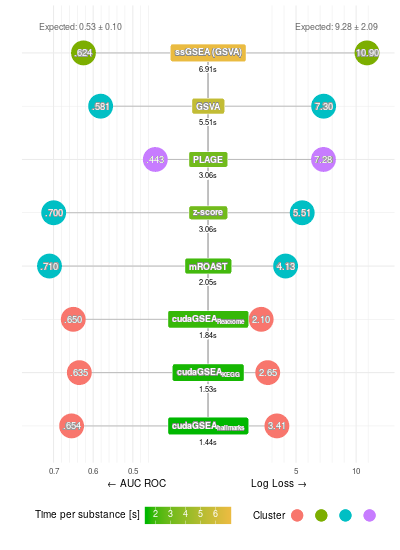

In [1433]:
%%R -i multi_sample_summary -i random_metrics_ms -w 400 -h 550
multi_sample_comparison = performance_plot(
    multi_sample_summary, random_metrics_ms, outlier_cutoff=60*60,
    left=c(breaks.zoom=10, minor_breaks.zoom=50),
    right=c(breaks.zoom=0.2, minor_breaks.zoom=1),
    up=c(
        unit='s',
        factor=1
    )
)
ggsave(
    file="multi_sample_BRCA_comparison.png",
    plot=multi_sample_comparison,
    width=4*1.3, height=5.5*1.3, dpi=350
)
multi_sample_comparison

### Chosen functions

- cudaGSEA Reactome (best log loss, good AUC),
- cudaGSEA hallmarks (best AUC),
- mROAST (faster than z-scorre, slightly better in both metrics).

Disqualified:
- ssGSEA: slowest, log loss worse than random
- PLAGE: slow, AUC worse than random

In [1521]:
from Benchmarking_setup import (
    gsea_score_phenotypes_cuda_hallmarks,
    gsea_score_phenotypes_cuda_reactome,
    roast_score_by_substance
)

In [1522]:
selected_multi_sample_functions = [
    gsea_score_phenotypes_cuda_hallmarks,
    gsea_score_phenotypes_cuda_reactome,
    roast_score_by_substance
]

## Single sample and multi sample comparison

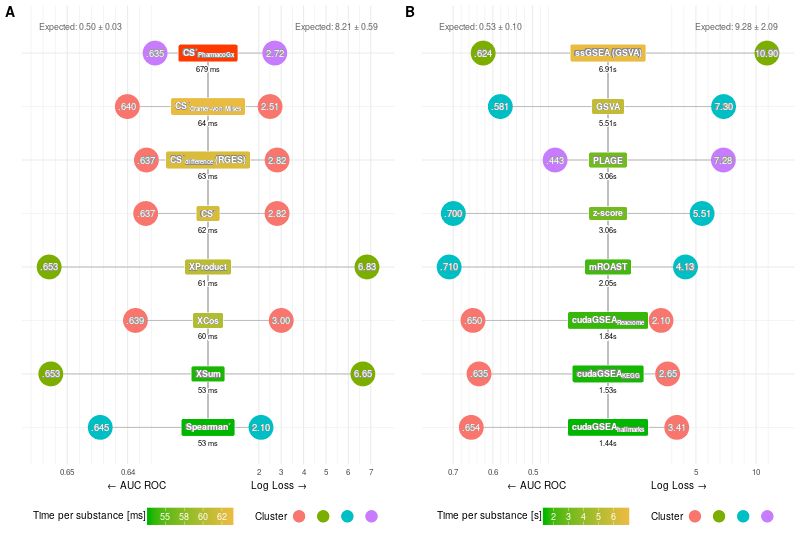

In [1439]:
%%R -w 800 -h 550
comparison = cowplot::plot_grid(
    single_sample_comparison,
    multi_sample_comparison,
    labels = c('A', 'B')
)
ggsave(
    file="BRCA_comparison.png",
    plot=comparison,
    width=2*4*1.45, height=5.5*1.45, dpi=350
)
comparison

## Single-sample gene-set based functions

Which were basically to slow to include them in the full benchmarks above:

In [63]:
functions_names(single_sample_gene_set_based)

['plage_100_mx_diff:True_single_sample',
 'gsva_100_mx_diff:True_single_sample',
 'ssgsea_100_mx_diff:True_single_sample',
 'zscore_100_mx_diff:True_single_sample',
 'GSEADesktop_1000_c2.cp.kegg_mean_0.05_fill_0_True_Gene_set_Diff_of_Classes',
 'GSEADesktop_1000_c2.cp.reactome_mean_0.05_fill_0_True_Gene_set_Diff_of_Classes',
 'GSEADesktop_1000_h.all_mean_0.05_fill_0_True_Gene_set_Diff_of_Classes']

In [66]:
single_sample_gene_set = brca_minimal_benchmark(
    # minimal benchmark as these are way slower than everything else
    single_sample_gene_set_based
)

'GeneSetCohorted_scored: 501 / 1000'

'GeneSetCohorted: 501 / 1000'

'shuffleGeneSet for GeneSet 21/30 nperm: 1000'

'GeneSetCohorted: 501 / 1000'

'GeneSetCohorted: 501 / 1000'

'GeneSetCohorted_scored: 501 / 1000'

In [79]:
# %store single_sample_gene_set

Stored 'single_sample_gene_set' (DataFrame)


In [ ]:
%store -r single_sample_gene_set

In [80]:
ss_gset_scores = extract_scores_from_result(
    single_sample_gene_set['meta:Scores'],
    scores_as_series=False
)

In [81]:
ss_gset_scores.to_csv('single_sample_gene_set_based_results.csv')

In [1071]:
ss_names = {
    'plage_100_mx_diff:True_single_sample': 'PLAGE_{ss}',
    'gsva_100_mx_diff:True_single_sample': 'GSVA_{ss}',
    'ssgsea_100_mx_diff:True_single_sample': 'ssGSEA_{ss}',
    'zscore_100_mx_diff:True_single_sample': 'zScore_{ss}',
    'GSEADesktop_1000_c2.cp.kegg_mean_0.05_fill_0_True_Gene_set_Diff_of_Classes': 'GSEA_{KEGG}',
    'GSEADesktop_1000_c2.cp.reactome_mean_0.05_fill_0_True_Gene_set_Diff_of_Classes': 'GSEA_{Reactome}',
    'GSEADesktop_1000_h.all_mean_0.05_fill_0_True_Gene_set_Diff_of_Classes': 'GSEA_{hallmark}'
}

In [1072]:
ss_gset_scores = read_csv('single_sample_gene_set_based_results.csv', index_col=0).reset_index()
ss_gset_scores = process_scores(ss_gset_scores, ss_names)

In [1073]:
ss_gset_scores

,index,Index,cell_id,func,group,...,pert_iname,score,raw_score,is_indication,known_indication
0,0,0,HCC515,PLAGE_{ss},indications,...,palbociclib,0.329744,0.353659,True,known indications
1,1,1,HCC515,PLAGE_{ss},indications,...,vinblastine,0.255383,0.319932,True,known indications
2,2,2,HCC515,PLAGE_{ss},indications,...,neratinib,0.037734,0.221212,True,known indications
3,3,3,HCC515,PLAGE_{ss},indications,...,everolimus,-0.009191,0.199928,True,known indications
4,4,4,HCC515,PLAGE_{ss},indications,...,epirubicin,-0.102807,0.157467,True,known indications
...,...,...,...,...,...,...,...,...,...,...,...
2935,2935,32,A549,GSEA_{hallmark},contraindications,...,levomepromazine,-0.527043,-0.289128,False,non-indications
2936,2936,33,A549,GSEA_{hallmark},contraindications,...,trifluoperazine,-0.557535,-0.307967,False,non-indications
2937,2937,34,A549,GSEA_{hallmark},contraindications,...,phylloquinone,-0.577197,-0.320116,False,non-indications
2938,2938,35,A549,GSEA_{hallmark},contraindications,...,iloperidone,-0.616204,-0.344218,False,non-indications


### Distribution plot

This one goes to the supplement (GSEA works fine, but it is too slow in this implementation)

/home/krassowski/.pyenv/versions/3.7.0/envs/drug_discovery/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "is_indication". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  (name, str(e)))


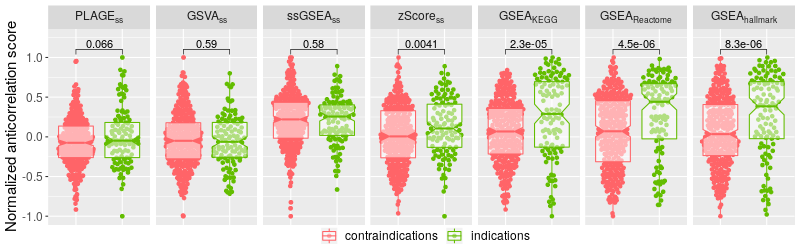

In [1482]:
%%R -i ss_gset_scores -w 800 -h 250
g = distribution_plot(
    ss_gset_scores,
    to_compare=list(
        c("indications", "contraindications")
    ),
    ncol=7,
    top_lim=1.25
)
ggsave(file="ss_gene_set_distribution.png", plot=g, width=8*1.3, height=2.5*1.3, dpi=350)
g

In [1493]:
matrix = distance_matrix(ss_gset_scores)

In [1494]:
clusters = clusters_from_matrix(matrix, 4)

In [1495]:
clusters

{'PLAGE_{ss}': 0,
 'GSVA_{ss}': 0,
 'ssGSEA_{ss}': 2,
 'zScore_{ss}': 3,
 'GSEA_{KEGG}': 1,
 'GSEA_{Reactome}': 1,
 'GSEA_{hallmark}': 1}

### Performance plot

In [1496]:
metrics_by_func = compute_metrics_by_func(ss_gset_scores, without_unassigned=True)
metrics_by_func

,auc,auc0.01,auc0.1,func,log_loss
0,0.547981,0.509887,0.535220,PLAGE_{ss},5.547589
1,0.492894,0.497589,0.493149,GSVA_{ss},5.682933
2,0.493269,0.497487,0.488704,ssGSEA_{ss},2.815675
3,0.583984,0.497487,0.527968,zScore_{ss},4.086749
4,0.629673,0.560050,0.610274,GSEA_{KEGG},3.318715
5,0.641146,0.500587,0.565411,GSEA_{Reactome},2.890870
6,0.636938,0.508236,0.566928,GSEA_{hallmark},2.997343


In [1497]:
substances_count = count_substances(ss_gset_scores)
substances_count

{'PLAGE_{ss}': 55,
 'GSVA_{ss}': 55,
 'ssGSEA_{ss}': 55,
 'zScore_{ss}': 55,
 'GSEA_{KEGG}': 55,
 'GSEA_{Reactome}': 55,
 'GSEA_{hallmark}': 55}

In [1498]:
ss_summary = functions_summary_frame(
    single_sample_gene_set, clusters,
    metrics_by_func, ss_names
)
ss_summary = add_time_per_substance(ss_summary, substances_count)
ss_summary

,auc,auc0.01,auc0.1,func,log_loss,time,cluster,time_rank,time_per_substance,time_nice
0,0.547981,0.509887,0.535220,PLAGE_{ss},5.547589,15300.567905,0,6.0,278.192144,278.19s
1,0.492894,0.497589,0.493149,GSVA_{ss},5.682933,8926.146824,0,4.0,162.293579,162.29s
2,0.493269,0.497487,0.488704,ssGSEA_{ss},2.815675,10170.110696,2,5.0,184.911104,184.91s
3,0.583984,0.497487,0.527968,zScore_{ss},4.086749,16487.961725,3,7.0,299.781122,299.78s
4,0.629673,0.560050,0.610274,GSEA_{KEGG},3.318715,717.370521,1,1.0,13.043100,13.04s
5,0.641146,0.500587,0.565411,GSEA_{Reactome},2.890870,907.071054,1,3.0,16.492201,16.49s
6,0.636938,0.508236,0.566928,GSEA_{hallmark},2.997343,809.897047,1,2.0,14.725401,14.73s


In [1499]:
random_metrics_ss = random_scores_metrics(
    ss_gene_sets_random_results,
    are_grouped_by_cell=True
)

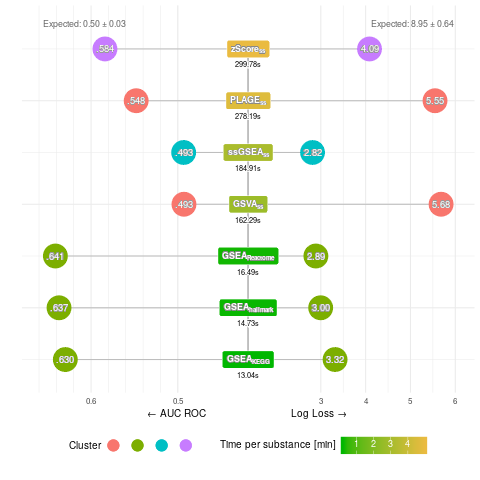

In [1503]:
%%R -i ss_summary -i random_metrics_ss
g = performance_plot(
    ss_summary, random_metrics_ss, outlier_cutoff=60*60*60,
    left=c(breaks.zoom=10, minor_breaks.zoom=50),
    right=c(breaks.zoom=1, minor_breaks.zoom=2),
    up=c(
        unit='min',
        factor=1/60
    )
)
ggsave(file="ss_gene_set_BRCA_comparison.png", plot=g, width=4.5*1.3, height=5.5*1.3, dpi=350)
g

# In depth analysis with selected functions

Further analyses on MCF7 cell line (the only cell line originating from a patient with breast cancer among analyzed) were conducted using the six promising functions:

In [1139]:
functions_names(selected_single_sample_functions)

['connectivity_score_signature_cramér_von_mises_difference',
 'x_sum',
 'score_spearman']

In [1140]:
functions_names(selected_multi_sample_functions)

['cudaGSEA_1000_h.all_mean_0.5_fill_0_True_phenotype_twopass_signal2noise',
 'cudaGSEA_1000_c2.cp.reactome_mean_0.5_fill_0_True_phenotype_twopass_signal2noise',
 'roast_score']

First, I compute scores for all unassigned substances (such scores were not computed for multi-sample functions up until this point):

In [ ]:
results_multi_sample_selected = brca_standard_benchmark(
    funcs=selected_multi_sample_functions,
    indications_signatures=data_brca.indications_singatures,
    contraindications_signatures=data_brca.contraindications_singatures,
    unassigned_signatures=all_other_selected,
    processes=12
)

In [39]:
#%store results_multi_sample_selected

Stored 'results_multi_sample_selected' (DataFrame)


In [ ]:
%store -r results_multi_sample_selected

And select relevant results from single sample calculations:

In [62]:
results_single_sample_selected = results_single_sample[results_single_sample.index.isin(
    functions_names(selected_single_sample_functions)
)]

In [63]:
def reload_and_process(scores, nice_names, save_path):
    scores.to_csv(save_path, index=False)
    scores = read_csv(save_path, index_col=0).reset_index()
    scores = process_scores(scores, nice_names)
    return scores

In [72]:
def n_best_in_group(scores, group):
    belongs_to_group = (scores.group == group)
    indications_by_func = scores[belongs_to_group].groupby('func')
    return n_best_scoring(scores, indications_by_func, n=5) 

In [166]:
# sss = Single Sample from Selected functions
sss_scores = extract_scores_from_result(
    results_single_sample_selected['meta:Scores'],
    scores_as_series=False
)
sss_scores.group = sss_scores.group.replace({'unknown_status': 'unassigned'})
# discard scores for controls (so we compare the same things)
sss_scores = sss_scores[sss_scores.group != 'controls']

### MCF7 cell line only (the breast cancer cell line):

In [ ]:
results_multi_sample_mcf7_selected = brca_standard_benchmark(
    funcs=selected_multi_sample_functions,
    indications_signatures=data_brca.indications_singatures,
    contraindications_signatures=data_brca.contraindications_singatures,
    unassigned_signatures=all_other_selected,
    processes=8,
    cell_lines={'MCF7'}
)

In [37]:
# %store results_multi_sample_mcf7_selected

Stored 'results_multi_sample_mcf7_selected' (DataFrame)


In [ ]:
%store -r results_multi_sample_mcf7_selected

In [433]:
sss_mcf7_scores = sss_scores[sss_scores.cell_id == 'MCF7']

In [434]:
mss_mcf7_scores = extract_scores_from_result(
    results_multi_sample_mcf7_selected['meta:Scores'],
    scores_as_series=False, are_grouped_by_cell=False
)

In [435]:
mcf7_scores = concat([
    sss_mcf7_scores.assign(kind='single sample'),
    mss_mcf7_scores.assign(kind='multi sample')
]).drop('Index', axis=1).reset_index(drop=True)
mcf7_scores = mcf7_scores.drop('cell_id', axis=1)

In [436]:
mcf7_scores['score'] = mcf7_scores.groupby(['func', 'pert_iname'])['score'].transform('mean')
mcf7_scores = mcf7_scores[mcf7_scores.columns.difference(['pert_idose'])].drop_duplicates()

In [456]:
nice_names_both = {**nice_function_names, **nice_multisample_function_names}

In [438]:
mcf7_scores = reload_and_process(
    mcf7_scores, nice_names_both,
    'results_selected_mcf7_by_substance.csv'
)

In [439]:
mcf7_scores.head()

,func,group,kind,pert_iname,score,raw_score,is_indication,known_indication,rank
0,Spearman',indications,single sample,tamoxifen,0.899344,0.577755,True,known indications,10.0
1,Spearman',indications,single sample,epirubicin,0.664349,0.444311,True,known indications,130.0
2,Spearman',indications,single sample,doxorubicin,0.594371,0.404573,True,known indications,226.0
3,Spearman',indications,single sample,methotrexate,0.584890,0.399189,True,known indications,241.0
4,Spearman',indications,single sample,cyclophosphamide,0.485812,0.342927,True,known indications,454.0


This approach did not work for multi-sample functions, as restriction to one cell line rendered the dataset to small for the signal to noise ratio differential expression metric (which requires at least 3 samples to compute variance), thus most of the substances were dropped:

In [440]:
show_table(mcf7_scores.groupby(['func', 'group']).score.count().to_frame())

score
func                   group                   
CS'_{Cramér–von Mises} contraindications  40   
                       indications        14   
                       unassigned         5350 
Spearman'              contraindications  40   
                       indications        14   
                       unassigned         5350 
XSum                   contraindications  40   
                       indications        14   
                       unassigned         5350 
mROAST                 contraindications  6    
                       indications        3    
                       unassigned         289  
cudaGSEA_{Reactome}    indications        1    
                       unassigned         10   
cudaGSEA_{hallmarks}   indications        1    
                       unassigned         9

#### Khinkali rank plot

In [441]:
top_mcf7 = concat([
    n_best_in_group(mcf7_scores, group).assign(group=group)
    for group in mcf7_scores.group.unique()
])

In [442]:
top_mcf7['label'] = top_mcf7.apply(
    lambda x: f'{int(x["rank"])}. {x["pert_iname"]}',
    axis=1
)
top_mcf7 = top_mcf7.reset_index()

In [443]:
top_mcf7 = top_mcf7.sort_values(['func', 'rank'])

In [444]:
top_mcf7.label = pd.Categorical(top_mcf7.label, ordered=True)

In [445]:
top_mcf7.head()

,func,group,kind,pert_iname,score,raw_score,is_indication,known_indication,rank,label
20,CS'_{Cramér–von Mises},unassigned,single sample,BRD-K58288048,1.000000,185.942048,False,non-indications,1.0,1. BRD-K58288048
21,CS'_{Cramér–von Mises},unassigned,single sample,SA-1017940,0.937840,175.451135,False,non-indications,2.0,2. SA-1017940
22,CS'_{Cramér–von Mises},unassigned,single sample,entinostat,0.930000,174.127902,False,non-indications,3.0,3. entinostat
23,CS'_{Cramér–von Mises},unassigned,single sample,BRD-K55116708,0.905546,170.000786,False,non-indications,4.0,4. BRD-K55116708
24,CS'_{Cramér–von Mises},unassigned,single sample,RJC-00245SC,0.891378,167.609595,False,non-indications,5.0,5. RJC-00245SC


In [511]:
%%R -i mcf7_scores -i top_mcf7

levels(mcf7_scores$func) = latex_levels(mcf7_scores, 'func')
levels(top_mcf7$func) = latex_levels(top_mcf7, 'func')


rank_labels = function(data, groups, x) {
    ggrepel::geom_label_repel(
        data=data[data$group %in% groups,],
        aes(label=label, y=rank, x=1, color=group, hjust=1),
        nudge_x=x,
        fill='white',
        direction='y',
        segment.size=0.6
    )
}

/home/krassowski/.pyenv/versions/3.7.0/envs/drug_discovery/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "is_indication". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  (name, str(e)))
/home/krassowski/.pyenv/versions/3.7.0/envs/drug_discovery/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "is_indication". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  (name, str(e)))


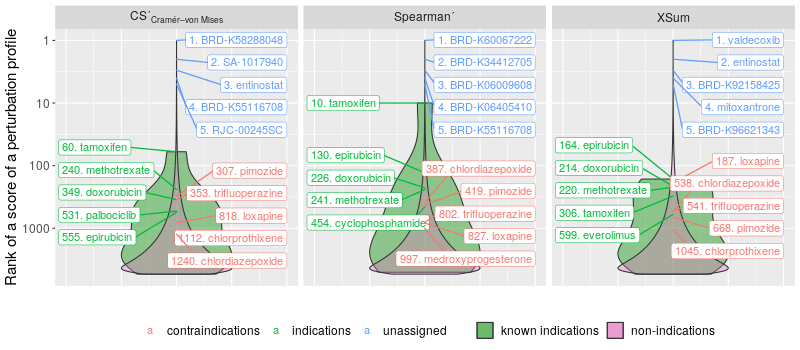

In [512]:
%%R -w 800 -h 350 -u px
top_ss = top_mcf7[top_mcf7$kind == 'single sample',]

g = (
    khinkali_plot(mcf7_scores[mcf7_scores$kind == 'single sample',], ncol=3)
    + rank_labels(top_ss, 'indications', -1)
    + rank_labels(top_ss, 'unassigned', 1)
    + rank_labels(top_ss, 'contraindications', 1)
    + khinkali_fill_colors()
    + guides(color=guide_legend(title=''))
    + xlim(0, 2)
)
ggsave(file="BRCA_MCF7_ss_top_among_all.png", plot=g, width=8*1.4, height=3.5*1.4)
g

This goes as a supplementary figure maybe (or maybe not):

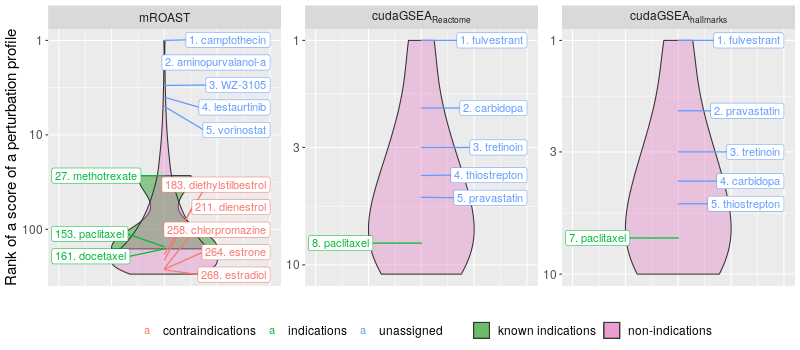

In [448]:
%%R -w 800 -h 350 -u px
top_ss = top_mcf7[top_mcf7$kind == 'multi sample',]

g = (
    khinkali_plot(mcf7_scores[mcf7_scores$kind == 'multi sample',], ncol=3,  scales='free_y')
    + rank_labels(top_ss, 'indications', -1)
    + rank_labels(top_ss, 'unassigned', 1)
    + rank_labels(top_ss, 'contraindications', 1)
    + khinkali_fill_colors()
    + guides(color=guide_legend(title=''))
    + xlim(0, 2)
)
ggsave(file="BRCA_MCF7_ms_top_among_all.png", plot=g, width=5.5*1.4, height=5.5*1.4)
g

### Results combined from across all concentrations and cell lines

In [462]:
mss_scores = extract_scores_from_result(
    results_multi_sample_selected['meta:Scores'],
    scores_as_series=False, are_grouped_by_cell=False
)

Normlize single samples by cell:

In [463]:
cell_normalized_sss_scores = normalize_scores(sss_scores, rescale=False, by_cell=True)
cell_normalized_sss_scores = cell_normalized_sss_scores.drop('raw_score', axis=1)

Merge with multi-sample:

In [469]:
sel_scores = concat([
    cell_normalized_sss_scores.assign(kind='single sample'),
    mss_scores.assign(kind='multi sample')
]).drop('Index', axis=1).reset_index(drop=True)

sel_scores = sel_scores.drop('cell_id', axis=1)

Aggregate across different doses (and cells for single-sample) and mean-average:

In [470]:
sel_scores['score'] = sel_scores.groupby(['func', 'pert_iname'])['score'].transform('mean')
# cells were dropped beforehand
sel_scores = sel_scores[sel_scores.columns.difference(['pert_idose'])].drop_duplicates()

Rescale and rebuild:

In [471]:
sel_scores = reload_and_process(sel_scores, nice_names_both, 'BRCA_results_selected_combined.csv')

In [493]:
sel_scores.head()

,func,group,kind,pert_iname,score,raw_score,is_indication,known_indication,rank
0,Spearman',indications,single sample,palbociclib,0.418827,1.698976,True,known indications,124.0
1,Spearman',indications,single sample,epirubicin,0.412712,1.681814,True,known indications,132.0
2,Spearman',indications,single sample,everolimus,0.412259,1.680542,True,known indications,134.0
3,Spearman',indications,single sample,cyclophosphamide,-0.100189,0.242115,True,known indications,2161.0
4,Spearman',indications,single sample,doxorubicin,0.439579,1.757226,True,known indications,98.0


#### Khinkali rank plot

In [474]:
top_selected = concat([
    n_best_in_group(sel_scores, group).assign(group=group)
    for group in sel_scores.group.unique()
])

In [475]:
top_selected['label'] = top_selected.apply(
    lambda x: f'{int(x["rank"])}. {x["pert_iname"]}',
    axis=1
)
top_selected = top_selected.reset_index()

In [478]:
top_selected.head()

,func,group,kind,pert_iname,score,raw_score,is_indication,known_indication,rank,label
0,CS'_{Cramér–von Mises},indications,single sample,everolimus,0.556805,1.910338,True,known indications,60.0,60. everolimus
1,CS'_{Cramér–von Mises},indications,single sample,epirubicin,0.503829,1.767838,True,known indications,108.0,108. epirubicin
2,CS'_{Cramér–von Mises},indications,single sample,doxorubicin,0.503290,1.766388,True,known indications,109.0,109. doxorubicin
3,CS'_{Cramér–von Mises},indications,single sample,palbociclib,0.412510,1.522202,True,known indications,184.0,184. palbociclib
4,CS'_{Cramér–von Mises},indications,single sample,tamoxifen,0.382643,1.441864,True,known indications,219.0,219. tamoxifen


/home/krassowski/.pyenv/versions/3.7.0/envs/drug_discovery/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "is_indication". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  (name, str(e)))
/home/krassowski/.pyenv/versions/3.7.0/envs/drug_discovery/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "is_indication". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  (name, str(e)))


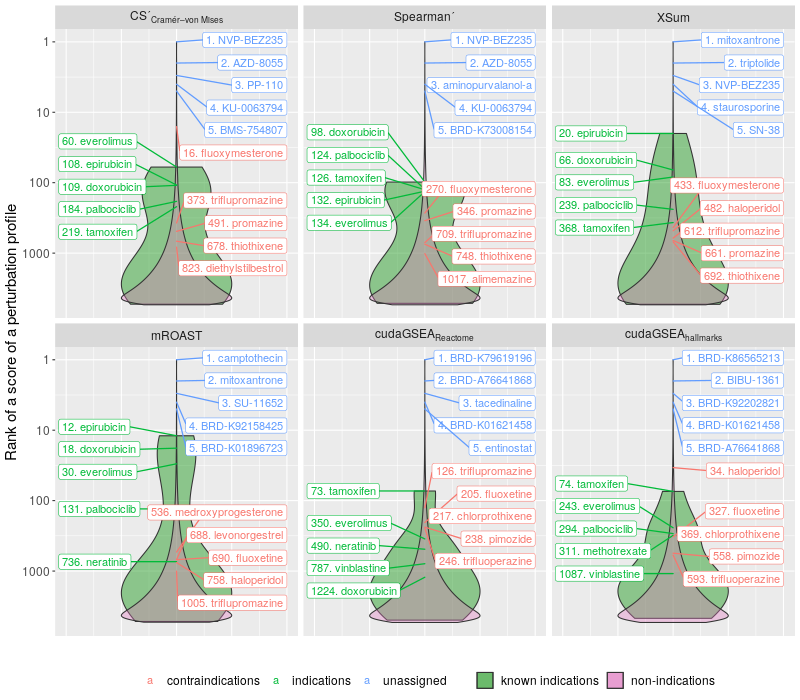

In [510]:
%%R -w 800 -h 700 -u px -i top_selected -i sel_scores
top_ss = top_selected

levels(top_ss$func) = latex_levels(top_ss, 'func')
levels(sel_scores$func) = latex_levels(sel_scores, 'func')

g = (
    khinkali_plot(sel_scores, ncol=3)
    + rank_labels(top_ss, 'indications', -1)
    + rank_labels(top_ss, c('unassigned', 'contraindications'), 1)
    + khinkali_fill_colors()
    + guides(color=guide_legend(title=''))
    + xlim(0, 2)
)
ggsave(file="BRCA_both_top_among_all.png", plot=g, width=8*1.4, height=8*1.4)
g

# TODO:
- case study of the top three contraindications and candidates (if time permits)
- verification on other cancers
- sensitivity, specificity AUC0.01, AUC0.1 (plotROC?)
- validation on RepoDB
- cell lines and dosage analysis for single-sample functions (not possible for multi-sample ones)
- results with stratification, stratification comparison